# LLM 训练实操训练 （LIHAI）

This tutorial uses architecture  from [MiniMind](https://github.com/jingyaogong/minimind), 

We modified the original code and provide this notebook for a step-by-step educational purpose.

The original structure graph demonstrates as below:

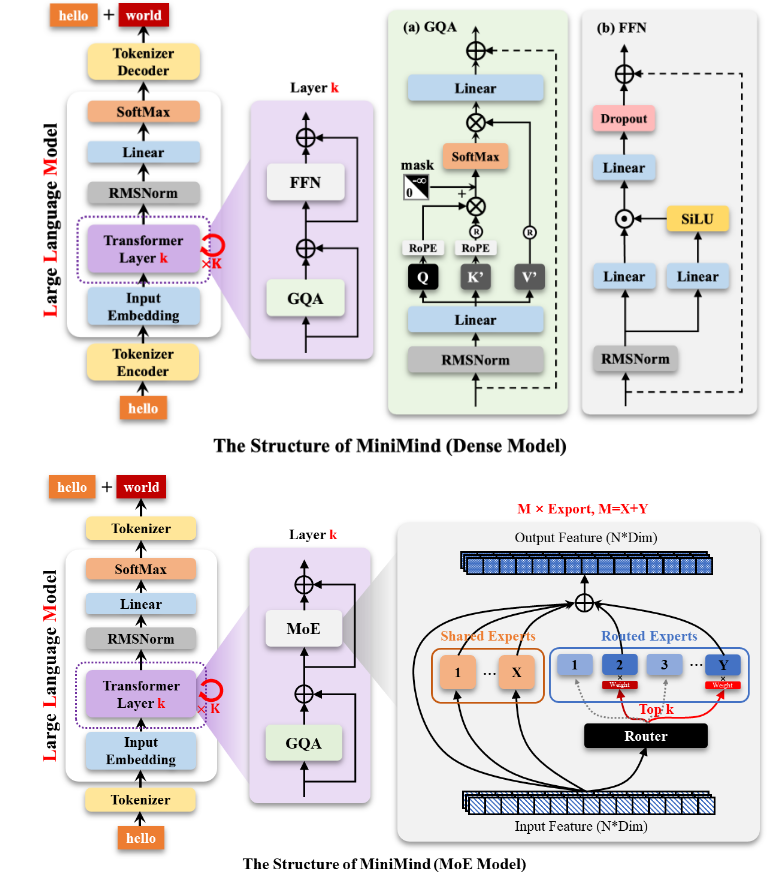

## 内容：

- **预训练 (Pretrain)**: 让模型学习基本语言建模能力  
- **SFT (Supervised Fine-tuning)**: 让模型更符合人类指令  
- **DPO (Direct Preference Optimization)**: 偏好学习，用于对齐人类偏好 (RLHF)  
- **知识蒸馏 (Knowledge Distillation)**: 用大模型指导小模型学习  
- **LoRA (Low-Rank Adaptation)**: 高效参数微调方法，节省显存  

## 2. 数据准备 (Dataset)

需下载 pretrain_hq.jsonl, lora_medical.jsonl, sftmini512, pretrainhq.
蒸馏teacher模型: full_sft_768


### 预训练数据
通常是大规模无监督语料 (jsonl 格式)：

```json
{"text": "今天天气很好，我们去公园玩。"}
{"text": "The quick brown fox jumps over the lazy dog."}


format:
{"text": "<|im_start|>小芳有6块巧克力...<|im_end|> <|im_start|>写一首五言诗...<|im_end|>"}

```

### SFT 数据
人工标注的指令 → 回复格式：

```json
{"instruction": "请用英文翻译：你好", "output": "Hello"}

format:
{"conversations": [
  {"role": "user", "content": "你好，你能告诉我你的全名吗？"},
  {"role": "assistant", "content": "你好，我的全名是Qwen..."}
]}
```

### DPO 数据
包含用户更喜欢的回答 (chosen) 与不喜欢的回答 (rejected)：

```json
{"prompt": "写一首诗", 
 "chosen": "白日依山尽，黄河入海流。", 
 "rejected": "今天天气不错。"
}

format:
{
  "chosen": [
    {"role": "user", "content": "From the numbers 1 to 150, how many numbers are neither perfect squares nor perfect cubes?"},
    {"role": "assistant", "content": "答案推导... \n最终结果是 134"}
  ],
  "rejected": [
    {"role": "user", "content": "From the numbers 1 to 150, how many numbers are neither perfect squares nor perfect cubes?"},
    {"role": "assistant", "content": "另一条错误的推导..."}
  ]
}
```

### LoRA Medical
与SFT 平行
```json
{"conversations": [
  {"role": "user", "content": "甲状腺乳头状癌切除手术后是否需要化疗甲？..."},
  {"role": "assistant", "content": "甲状腺乳头状癌是一种常见的甲状腺癌..."}
]}
```

### Distillation

```json
{"conversations": [
  {"role": "user", "content": "机器学习是一门研究如何让计算机从数据中自动学习的学科。"},
  {"role": "teacher", "content": "teacher_logits: [0.1, 0.05, 0.8, ...]"}
]}
```

---


# Pretrain
py 3.10

cuda : pip install torch==2.3.0 --index-url https://download.pytorch.org/whl/cu121

In [ ]:
# !pip install -r requirements_modified.txt -i https://pypi.tuna.tsinghua.edu.cn/simple

# #然后确保cuda gpu_ver

# !pip install torch==2.3.0 --index-url https://download.pytorch.org/whl/cu121

env check

In [3]:
import os, sys, platform, torch
from pathlib import Path
project_root = Path.cwd().resolve()  
sys.path.append(str(project_root))
print("Project root:", project_root)
print("Python:", sys.executable)
print("Torch:", torch.__version__, "CUDA in wheel:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available(), "Count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Device name:", torch.cuda.get_device_name(0))

Project root: C:\Users\lvbab\Desktop\minitest
Python: c:\Users\lvbab\anaconda3\envs\mini310\python.exe
Torch: 2.3.0+cu121 CUDA in wheel: 12.1
CUDA available: True Count: 1
Device name: NVIDIA GeForce RTX 4070 Ti


预训练的目标是让模型学会预测下一个 token，核心是语言建模损失：

$$
\mathcal{L}_{LM} = - \sum_{t} \log P_\theta(y_t \mid y_{<t})
$$

其中，$y_t$ 是第 $t$ 个 token，$P_\theta$ 是参数化的语言模型。


学习率采用cosine decay：

$$
\text{lr}(k) = \frac{\text{lr}_0}{10} + \frac{1}{2}\,\text{lr}_0 \Big(1 + \cos\Big(\frac{\pi k}{K}\Big)\Big)
$$

其中 $k$ 是当前 step，$K$ 是总步数。


In [4]:

import time, math, warnings
import torch
import torch.distributed as dist
from torch import optim, nn
from torch.nn.parallel import DistributedDataParallel
from torch.utils.data import DataLoader, DistributedSampler
from contextlib import nullcontext
from transformers import AutoTokenizer
from model.model_minimind import MiniMindConfig, MiniMindForCausalLM
from dataset.lm_dataset import PretrainDataset

warnings.filterwarnings('ignore')

def Logger(content, ddp=False):
    if not ddp or dist.get_rank() == 0:
        print(content)


def get_lr(current_step, total_steps, lr):
    return lr / 10 + 0.5 * lr * (1 + math.cos(math.pi * current_step / total_steps))

c:\Users\lvbab\anaconda3\envs\mini310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Settings

In [ ]:

from types import SimpleNamespace
from pathlib import Path

args = SimpleNamespace(
    out_dir = "./out",
    epochs = 1,                    # 演示先从 1 开始
    batch_size = 32,
    learning_rate = 5e-4,
    device = "cuda:0" if torch.cuda.is_available() else "cpu",
    dtype = "bfloat16",            # 若遇到问题可改 "float16"
    use_wandb = False,
    wandb_project = "MiniMind-Pretrain",
    num_workers = 1,
    ddp = False,                   # 一般单卡，先 False
    accumulation_steps = 8,
    grad_clip = 1.0,
    warmup_iters = 0,
    log_interval = 100,
    save_interval = 100,            
    hidden_size = 512,
    num_hidden_layers = 8,
    max_seq_len = 512,
    use_moe = False,
    data_path = "./dataset/pretrain_hq.jsonl",   # 修改为你的数据
)

# 创建输出目录
Path(args.out_dir).mkdir(parents=True, exist_ok=True)
device_type = "cuda" if "cuda" in args.device else "cpu"
from contextlib import nullcontext
ctx = nullcontext() if device_type == "cpu" else torch.cuda.amp.autocast()
Logger(f"Using device: {args.device}")


Using device: cuda:0


Tokenizer and init

In [6]:
tokenizer_path = str(project_root / "model")
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

lm_config = MiniMindConfig(hidden_size=args.hidden_size, num_hidden_layers=args.num_hidden_layers, use_moe=args.use_moe)
model = MiniMindForCausalLM(lm_config).to(args.device)

trainable_params_m = sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6
Logger(f"Total Params：{trainable_params_m:.3f} M")

Total Params：25.830 M


Load

In [7]:

from pathlib import Path

data_path = str((project_root / args.data_path).resolve()) if not Path(args.data_path).exists() else args.data_path
assert Path(data_path).exists(), f"数据文件不存在：{data_path}"
train_ds = PretrainDataset(data_path, tokenizer, max_length=args.max_seq_len)
train_sampler = DistributedSampler(train_ds) if args.ddp else None
train_loader = DataLoader(
    train_ds,
    batch_size=args.batch_size,
    pin_memory=True,
    drop_last=False,
    shuffle=False,
    num_workers=args.num_workers,
    sampler=train_sampler
)
iter_per_epoch = len(train_loader)
Logger(f"iter_per_epoch = {iter_per_epoch}")
scaler = torch.cuda.amp.GradScaler(enabled=(args.dtype in ['float16', 'bfloat16']))
optimizer = optim.AdamW(model.parameters(), lr=args.learning_rate)

iter_per_epoch = 44160


Train

In [8]:
def save_ckpt(epoch, print_msg=False):
    model.eval()
    moe_path = '_moe' if args.use_moe else ''
    fn = f'pretrain_{args.hidden_size}{moe_path}_{epoch}.pth'
    ckp = str(Path(args.out_dir) / fn)
    state_dict = model.state_dict()
    state_dict = {k: v.half() for k, v in state_dict.items()}
    torch.save(state_dict, ckp)
    if print_msg:
        Logger(f"Saved: {ckp}")
    model.train()

In [ ]:

def train_epoch(epoch, wandb=None, ddp=False):
    loss_fct = nn.CrossEntropyLoss(reduction='none')
    start_time = time.time()
    model.train()
    for step, (X, Y, loss_mask) in enumerate(train_loader):
        X = X.to(args.device); Y = Y.to(args.device); loss_mask = loss_mask.to(args.device)

        lr = get_lr(epoch * iter_per_epoch + step, args.epochs * iter_per_epoch, args.learning_rate)
        for param_group in optimizer.param_groups: param_group['lr'] = lr

        with ctx:
            res = model(X)
            loss = loss_fct(res.logits.view(-1, res.logits.size(-1)), Y.view(-1)).view(Y.size())
            loss = (loss * loss_mask).sum() / loss_mask.sum()
            loss = loss + getattr(res, "aux_loss", 0.0)
            loss = loss / args.accumulation_steps

        scaler.scale(loss).backward()

        if (step + 1) % args.accumulation_steps == 0:
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), args.grad_clip)
            scaler.step(optimizer); scaler.update()
            optimizer.zero_grad(set_to_none=True)

        if step % args.log_interval == 0:
            spend_time = time.time() - start_time
            eta_min = int(spend_time / (step + 1) * iter_per_epoch // 60 - spend_time // 60)
            Logger(f"Epoch:[{epoch+1}/{args.epochs}]({step}/{iter_per_epoch}) "
                   f"loss:{loss.item()*args.accumulation_steps:.3f} lr:{optimizer.param_groups[-1]['lr']:.12f} "
                   f"epoch_Time:{eta_min}min:")
 
        # set save_interval check for 0 not saving
        if args.save_interval and (step + 1) % args.save_interval == 0:
            save_ckpt(epoch)
        


In [47]:

# for epoch in range(args.epochs):
#     train_epoch(epoch, wandb=None, ddp=False)
# save_ckpt(epoch, print_msg=True)

## SFT

在人工标注的指令数据上继续训练，目标函数与预训练类似：

$$
\mathcal{L}_{SFT} = - \sum_{t} \log P_\theta(y_t \mid x, y_{<t})
$$


In [ ]:
# SFT extra import 
from dataset.lm_dataset import SFTDataset   # SFT dataset


from types import SimpleNamespace
import os

In [ ]:

sft = SimpleNamespace(
    out_dir       = "./out",
    epochs        = 2,
    batch_size    = 16,
    learning_rate = 5e-7,
    device        = "cuda:0" if torch.cuda.is_available() else "cpu",
    dtype         = "bfloat16",
    use_wandb     = False,
    wandb_project = "MiniMind-Full-SFT",
    num_workers   = 1,
    ddp           = False,
    accumulation_steps = 1,
    grad_clip     = 1.0,
    warmup_iters  = 0,
    log_interval  = 100,
    save_interval = 0,
    hidden_size   = 512,
    num_hidden_layers = 8,
    max_seq_len   = 512,
    use_moe       = False,
    tokenizer_path = "./model",
    data_path      = "./dataset/sft_mini_512.jsonl",
)

moe = '_moe' if sft.use_moe else ''

def save_ckpt_sft(tag=None):
    model.eval()
    fname = f"full_sft_{sft.hidden_size}{moe}.pth"   # 每次覆盖同名文件
    ckp = os.path.join(sft.out_dir, fname)
    state_dict = model.state_dict()
    state_dict = {k: v.half() for k,v in state_dict.items()}
    torch.save(state_dict, ckp)
    Logger(f"Saved: {os.path.abspath(ckp)}")
    model.train()




In [ ]:


pretrain_ckpt = os.path.join(sft.out_dir, f"pretrain_{sft.hidden_size}{moe}.pth")

from contextlib import nullcontext
ctx = nullcontext() if ("cuda" not in sft.device) else torch.cuda.amp.autocast()


def init_model_sft(cfg):
    tokenizer = AutoTokenizer.from_pretrained(cfg.tokenizer_path)

    lm_config = MiniMindConfig(
        hidden_size=cfg.hidden_size,
        num_hidden_layers=cfg.num_hidden_layers,
        use_moe=cfg.use_moe,
    )
    model = MiniMindForCausalLM(lm_config)

    assert os.path.exists(pretrain_ckpt), f"找不到预训练权重：{pretrain_ckpt}"
    state = torch.load(pretrain_ckpt, map_location=cfg.device)
    model.load_state_dict(state, strict=False)

    model = model.to(cfg.device)
    Logger(f"SFT 模型参数量：{sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6:.3f} 百万")
    return model, tokenizer, lm_config


model, tokenizer, lm_config = init_model_sft(sft)

assert os.path.exists(sft.data_path), f"数据文件不存在：{sft.data_path}"
train_ds = SFTDataset(sft.data_path, tokenizer, max_length=sft.max_seq_len)
train_sampler = DistributedSampler(train_ds) if sft.ddp else None
train_loader = DataLoader(
    train_ds,
    batch_size=sft.batch_size,
    pin_memory=True,
    drop_last=False,
    shuffle=False,
    num_workers=sft.num_workers,
    sampler=train_sampler
)
iter_per_epoch = len(train_loader)

scaler = torch.cuda.amp.GradScaler(enabled=(sft.dtype in ['float16','bfloat16']))
optimizer = optim.AdamW(model.parameters(), lr=sft.learning_rate)


In [ ]:

args = sft  # 让 train_epoch 用到 sft 配置
for epoch in range(sft.epochs):
    train_epoch(epoch, wandb=None, ddp=False)   # 直接用 pretrain 的 train_epoch
    save_ckpt_sft(tag=f"_epoch{epoch+1}")


## DPO (RLHF)


DPO 的目标是让模型偏向人类偏好的答案。损失函数：

$$
\mathcal{L}_{DPO} = - \mathbb{E}_{(x,y^+,y^-)} \Bigg[
    \log \sigma \Big(
        \beta \big[
            (\log \pi_\theta(y^+|x) - \log \pi_\theta(y^-|x)) -
            (\log \pi_{ref}(y^+|x) - \log \pi_{ref}(y^-|x))
        \big]
    \Big)
\Bigg]
$$

- $y^+$: 人类偏好的回答 (chosen)  
- $y^-$: 人类不喜欢的回答 (rejected)  
- $\pi_{ref}$: 参考模型 (通常是 SFT 模型的冻结版本)  



In [33]:
from dataset.lm_dataset import DPODataset  
import torch.nn.functional as F
import os


In [ ]:
from types import SimpleNamespace
from contextlib import nullcontext

dpo = SimpleNamespace(
    out_dir       = "./out",
    tokenizer_path= "./model",                   
    data_path     = "./dataset/dpo.jsonl",       # DPO 偏好数据
    device        = "cuda:0" if torch.cuda.is_available() else "cpu",
    dtype         = "bfloat16",
    batch_size    = 4,                           # DPO 通常小 batch
    epochs        = 2,
    learning_rate = 1e-8,                        # 极小 LR
    num_workers   = 1,
    accumulation_steps = 1,
    grad_clip     = 1.0,
    log_interval  = 100,
    save_interval = 0,                           # =0 关闭步内保存，只在 epoch 末保存
    hidden_size   = 512,
    num_hidden_layers = 8,
    max_seq_len   = 1024,                        # DPO 通常用较长序列
    use_moe       = False,
    beta          = 0.1,                         # DPO 温度系数（你脚本的默认）
)

moe = "_moe" if dpo.use_moe else ""
sft_ckpt = os.path.join(dpo.out_dir, f"full_sft_{dpo.hidden_size}{moe}.pth")  # SFT 产物作为起点
os.makedirs(dpo.out_dir, exist_ok=True)

ctx = nullcontext() if ("cuda" not in dpo.device) else torch.cuda.amp.autocast()


In [35]:
# tokenizer 与模型结构
tokenizer = AutoTokenizer.from_pretrained(dpo.tokenizer_path)

lm_config = MiniMindConfig(
    hidden_size=dpo.hidden_size,
    num_hidden_layers=dpo.num_hidden_layers,
    use_moe=dpo.use_moe,
)

# policy（要训练）
policy = MiniMindForCausalLM(lm_config).to(dpo.device)
assert os.path.exists(sft_ckpt), f"找不到 SFT 权重：{sft_ckpt}"
policy.load_state_dict(torch.load(sft_ckpt, map_location=dpo.device), strict=False)

# reference（不训练，用来对比）
reference = MiniMindForCausalLM(lm_config).to(dpo.device)
reference.load_state_dict(torch.load(sft_ckpt, map_location=dpo.device), strict=False)
for p in reference.parameters():
    p.requires_grad = False
reference.eval()

Logger(f"Policy 可训练参数量：{sum(p.numel() for p in policy.parameters() if p.requires_grad)/1e6:.3f} 百万")


Policy 可训练参数量：25.830 百万


In [36]:
train_ds = DPODataset(dpo.data_path, tokenizer, max_length=dpo.max_seq_len)
train_loader = DataLoader(
    train_ds,
    batch_size=dpo.batch_size,
    pin_memory=True,
    drop_last=False,
    shuffle=False,
    num_workers=dpo.num_workers,
)
iter_per_epoch = len(train_loader)

scaler = torch.cuda.amp.GradScaler(enabled=(dpo.dtype in ["float16","bfloat16"]))
optimizer = optim.AdamW(policy.parameters(), lr=dpo.learning_rate)

# 让共享的 get_lr 可以继续用（用 dpo 这套 total_steps）
total_steps = dpo.epochs * iter_per_epoch


In [ ]:
def _masked_mean_logprob(logits, Y, loss_mask):
    # logits: [B, T, V]; Y: [B, T]; loss_mask: [B, T]
    logprobs = F.log_softmax(logits, dim=-1)
    token_logp = logprobs.gather(dim=-1, index=Y.unsqueeze(-1)).squeeze(-1)  # [B, T]
    # 按 mask 平均
    token_logp = token_logp * loss_mask
    denom = loss_mask.sum(dim=1).clamp(min=1)
    return token_logp.sum(dim=1) / denom  # [B]

def dpo_loss(policy_out, ref_out, Y, loss_mask, beta):
    """
    假定 batch = [chosen; rejected]
    """
    B = Y.size(0); half = B // 2
    # 平均到序列级别
    p_logp = _masked_mean_logprob(policy_out.logits, Y, loss_mask)
    r_logp = _masked_mean_logprob(ref_out.logits,   Y, loss_mask).detach()

    p_ch, p_rj = p_logp[:half], p_logp[half:]
    r_ch, r_rj = r_logp[:half], r_logp[half:]

    # 公式： -log σ( β * [ (p_ch - p_rj) - (r_ch - r_rj) ] )
    advantage = (p_ch - p_rj) - (r_ch - r_rj)
    return -F.logsigmoid(beta * advantage).mean()

def save_ckpt_dpo(tag=None):
    policy.eval()
    fname = f"rlhf_{dpo.hidden_size}{moe}.pth"   # cover
    ckp = os.path.join(dpo.out_dir, fname)
    state_dict = policy.state_dict()
    state_dict = {k: v.half() for k, v in state_dict.items()}
    torch.save(state_dict, ckp)
    Logger(f"Saved: {os.path.abspath(ckp)}")
    policy.train()


In [ ]:
def train_epoch_dpo(epoch, wandb=None):
    policy.train()
    start = time.time()
    for step, batch in enumerate(train_loader):
        x_chosen     = batch['x_chosen'].to(dpo.device)
        x_rejected   = batch['x_rejected'].to(dpo.device)
        y_chosen     = batch['y_chosen'].to(dpo.device)
        y_rejected   = batch['y_rejected'].to(dpo.device)
        mask_chosen  = batch['mask_chosen'].to(dpo.device)
        mask_rejected= batch['mask_rejected'].to(dpo.device)

        X = torch.cat([x_chosen,    x_rejected],    dim=0)
        Y = torch.cat([y_chosen,    y_rejected],    dim=0)
        loss_mask = torch.cat([mask_chosen, mask_rejected], dim=0)

        X = X.to(dpo.device); Y = Y.to(dpo.device); loss_mask = loss_mask.to(dpo.device)

        lr = get_lr(epoch * iter_per_epoch + step, total_steps, dpo.learning_rate)
        for pg in optimizer.param_groups: pg["lr"] = lr

        with ctx:
            # 先跑 reference（无梯度）
            with torch.no_grad():
                ref_out = reference(X)
            # 再跑 policy（带梯度）
            pol_out = policy(X)

            loss = dpo_loss(pol_out, ref_out, Y, loss_mask, beta=dpo.beta)
            loss = loss / dpo.accumulation_steps

        scaler.scale(loss).backward()

        if (step + 1) % dpo.accumulation_steps == 0:
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(policy.parameters(), dpo.grad_clip)
            scaler.step(optimizer); scaler.update()
            optimizer.zero_grad(set_to_none=True)

        if step % dpo.log_interval == 0:
            spend = time.time() - start
            eta_min = int(spend / (step + 1) * iter_per_epoch // 60 - spend // 60)
            Logger(f"[DPO] Epoch[{epoch+1}/{dpo.epochs}]({step}/{iter_per_epoch}) "
                   f"loss:{(loss.item()*dpo.accumulation_steps):.5f} lr:{optimizer.param_groups[-1]['lr']:.12e} "
                   f"epoch_Time:{eta_min}min:")

        if dpo.save_interval and ((step + 1) % dpo.save_interval == 0):
            save_ckpt_dpo(tag=f"step{step+1}")


In [42]:
# for epoch in range(dpo.epochs):
#     train_epoch_dpo(epoch, wandb=None)
#     save_ckpt_dpo(tag=f"epoch{epoch+1}")


## Distillation

知识蒸馏通过 teacher 的 soft target 来指导 student：

$$
\mathcal{L}_{KD} = \text{KL}(P_{teacher}(y|x) \,\|\, P_{student}(y|x))
$$

这能让小模型模仿大模型的分布。

In [ ]:
from types import SimpleNamespace
import os

kd = SimpleNamespace(
    # 路径
    tokenizer_path = "./model",
    data_path      = "./dataset/sft_mini_512.jsonl",   # 用 SFT 格式更合理
    teacher_path   = "./out/full_sft_768.pth",         # 老师 ckpt（建议 SFT 后的大模型）
    student_path   = "./out/pretrain_512.pth",         # 学生初始 ckpt（可用 pretrain 或 SFT 小模型）
    out_dir        = "./out",

    # 规模（保持与你的模型类一致）
    teacher_hidden_size = 768,
    teacher_num_layers  = 16,
    student_hidden_size = 512,
    student_num_layers  = 8,

    # 训练超参
    device        = "cuda:0" if torch.cuda.is_available() else "cpu",
    dtype         = "bfloat16",
    epochs        = 1,
    batch_size    = 16,
    learning_rate = 5e-6,           # KD 一般比纯 SFT 稍大于 5e-7；按需调
    accumulation_steps = 1,
    grad_clip     = 1.0,
    num_workers   = 1,
    log_interval  = 100,
    save_interval = 0,              # 0 turn off
    ddp           = False,

    # KD 关键参数
    alpha       = 0.5,              # 任务 CE 和 KL weights
    temperature = 2.0,              # 蒸馏温度 T
)

os.makedirs(kd.out_dir, exist_ok=True)
ctx = nullcontext() if ("cuda" not in kd.device) else torch.cuda.amp.autocast()


In [ ]:
from transformers import AutoTokenizer
from model.model_minimind import MiniMindConfig, MiniMindForCausalLM

def init_teacher_student(cfg):
    tokenizer = AutoTokenizer.from_pretrained(cfg.tokenizer_path)

    # teacher（更大）
    t_cfg = MiniMindConfig(hidden_size=cfg.teacher_hidden_size,
                           num_hidden_layers=cfg.teacher_num_layers,
                           use_moe=False)
    teacher = MiniMindForCausalLM(t_cfg).to(cfg.device)
    assert os.path.exists(cfg.teacher_path), f"teacher ckpt 不存在：{cfg.teacher_path}"
    t_state = torch.load(cfg.teacher_path, map_location=cfg.device)
    teacher.load_state_dict(t_state, strict=False)
    for p in teacher.parameters(): p.requires_grad = False
    teacher.eval()

    # student（更小）
    s_cfg = MiniMindConfig(hidden_size=cfg.student_hidden_size,
                           num_hidden_layers=cfg.student_num_layers,
                           use_moe=False)
    student = MiniMindForCausalLM(s_cfg).to(cfg.device)
    assert os.path.exists(cfg.student_path), f"student 初始 ckpt 不存在：{cfg.student_path}"
    s_state = torch.load(cfg.student_path, map_location=cfg.device)
    student.load_state_dict(s_state, strict=False)

    Logger(f"Teacher params: {sum(p.numel() for p in teacher.parameters())/1e6:.1f} M | "
           f"Student params: {sum(p.numel() for p in student.parameters())/1e6:.1f} M")
    return teacher, student, tokenizer


In [ ]:
from dataset.lm_dataset import SFTDataset
from torch.utils.data import DataLoader, DistributedSampler
from torch import optim, nn
import torch.nn.functional as F
from pathlib import Path

teacher, model, tokenizer = init_teacher_student(kd)

assert os.path.exists(kd.data_path), f"数据文件不存在：{kd.data_path}"
train_ds = SFTDataset(kd.data_path, tokenizer, max_length=512)
train_sampler = DistributedSampler(train_ds) if kd.ddp else None
train_loader = DataLoader(
    train_ds,
    batch_size=kd.batch_size,
    pin_memory=True,
    drop_last=False,
    shuffle=False,
    num_workers=kd.num_workers,
    sampler=train_sampler
)
iter_per_epoch = len(train_loader)

scaler = torch.cuda.amp.GradScaler(enabled=(kd.dtype in ['float16','bfloat16']))
optimizer = optim.AdamW(model.parameters(), lr=kd.learning_rate)

def save_ckpt_distill(tag=None):
    model.eval()
    fn  = f"distill_{kd.student_hidden_size}.pth"     # cover
    ckp = str(Path(kd.out_dir) / fn)
    state = model.state_dict()
    state = {k: v.half() for k, v in state.items()}
    torch.save(state, ckp)
    Logger(f"Saved: {os.path.abspath(ckp)}")
    model.train()


Teacher params: 104.0 M | Student params: 25.8 M


In [ ]:
def kd_token_loss(student_logits, teacher_logits, labels, loss_mask, T, alpha):
    """
    student_logits/teacher_logits: [B, L, V]
    labels: [B, L]
    loss_mask: [B, L]  (SFT 里通常只在答案段为 1)
    """
    B, L, V = student_logits.shape
    # 任务 CE（和你 pretrain/SFT 一样的做法）
    ce = nn.CrossEntropyLoss(reduction='none')
    ce_loss = ce(student_logits.view(-1, V), labels.view(-1)).view(B, L)
    ce_loss = (ce_loss * loss_mask).sum() / loss_mask.sum()

    # KL 蒸馏（注意 T^2 放缩）
    s_logp = F.log_softmax(student_logits / T, dim=-1)   # log prob
    with torch.no_grad():
        t_prob = F.softmax(teacher_logits / T, dim=-1)   # prob (不需要 log)
    kl = F.kl_div(s_logp, t_prob, reduction='none')      # [B, L, V]
    kl = kl.sum(dim=-1)                                  # [B, L]，对 vocab 求和
    kl = (kl * loss_mask).sum() / loss_mask.sum()

    return alpha * ce_loss + (1 - alpha) * (T * T) * kl


In [ ]:
def train_epoch_kd(epoch):
    loss_fct = nn.CrossEntropyLoss(reduction='none')  
    start_time = time.time()
    model.train()

    for step, (X, Y, loss_mask) in enumerate(train_loader):
        X = X.to(kd.device); Y = Y.to(kd.device); loss_mask = loss_mask.to(kd.device)

        lr = get_lr(epoch * iter_per_epoch + step, kd.epochs * iter_per_epoch, kd.learning_rate)
        for pg in optimizer.param_groups: pg['lr'] = lr

        with ctx:
            with torch.no_grad():
                t_out = teacher(X)                  # teacher forward（冻结/无梯度）
            s_out = model(X)
            loss = kd_token_loss(
                s_out.logits, t_out.logits, Y, loss_mask,
                T=kd.temperature, alpha=kd.alpha
            )
            loss = loss / kd.accumulation_steps

        scaler.scale(loss).backward()

        if (step + 1) % kd.accumulation_steps == 0:
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), kd.grad_clip)
            scaler.step(optimizer); scaler.update()
            optimizer.zero_grad(set_to_none=True)

        if step % kd.log_interval == 0:
            spend = time.time() - start_time
            eta_min = int(spend / (step + 1) * iter_per_epoch // 60 - spend // 60)
            Logger(f"[KD] Epoch:[{epoch+1}/{kd.epochs}]({step}/{iter_per_epoch}) "
                   f"loss:{loss.item()*kd.accumulation_steps:.3f} lr:{optimizer.param_groups[-1]['lr']:.12f} "
                   f"epoch_Time:{eta_min}min:")

        # 步内保存（允许 0 跳过）
        if getattr(kd, "save_interval", 0) and ((step + 1) % kd.save_interval == 0):
            save_ckpt_distill(tag=f"step{step+1}")


In [43]:
# for epoch in range(kd.epochs):
#     train_epoch_kd(epoch)
#     save_ckpt_distill(tag=f"epoch{epoch+1}")


## Fine-Tuning LoRA

LoRA 的核心思想是在大矩阵上添加低秩适配器：

$$
W' = W + BA, \quad A \in \mathbb{R}^{r \times d}, \, B \in \mathbb{R}^{d \times r}, \, r \ll d
$$


In [ ]:

from dataset.lm_dataset import SFTDataset
from model.model_lora import load_lora, save_lora, apply_lora 
import os

from types import SimpleNamespace
lora = SimpleNamespace(
    out_dir       = "./out",
    data_path     = "./dataset/lora_medical.jsonl",
    tokenizer_path= "./model",
    device        = "cuda:0" if torch.cuda.is_available() else "cpu",
    dtype         = "bfloat16",
    batch_size    = 32,
    epochs        = 10,
    learning_rate = 1e-4,
    num_workers   = 1,
    accumulation_steps = 1,
    grad_clip     = 1.0,
    log_interval  = 100,
    save_interval = 100,          # =0 可关闭步内保存，只在 epoch 收尾保存
    hidden_size   = 512,
    num_hidden_layers = 8,
    max_seq_len   = 512,
    use_moe       = False,
    lora_name     = "lora_medical",  # 用任务名命名适配器
)

# 基座：用“全量 SFT 训练好的模型”当底座，再挂 LoRA
base_ckpt = os.path.join(lora.out_dir, f"pretrain_{lora.hidden_size}.pth")  # choice base
assert os.path.exists(base_ckpt), f"找不到基础权重：{base_ckpt}"


In [ ]:

tokenizer = AutoTokenizer.from_pretrained(lora.tokenizer_path)
lm_config = MiniMindConfig(hidden_size=lora.hidden_size, num_hidden_layers=lora.num_hidden_layers, use_moe=lora.use_moe)
model = MiniMindForCausalLM(lm_config).to(lora.device)

state = torch.load(base_ckpt, map_location=lora.device)     # 加载全量 SFT 的底座
model.load_state_dict(state, strict=False)

apply_lora(model)  # ★ 挂上 LoRA 适配器

# 冻结非 LoRA 参数，仅训练 LoRA
for name, p in model.named_parameters():
    p.requires_grad = ('lora' in name)

# 统计 LoRA 开销
total_params = sum(p.numel() for p in model.parameters())
lora_params  = sum(p.numel() for n,p in model.named_parameters() if p.requires_grad)
Logger(f"LLM 总参: {total_params} | LoRA 参: {lora_params} ({lora_params/total_params*100:.2f}%)")


LLM 总参: 25960960 | LoRA 参: 131072 (0.50%)


In [ ]:
#DataLoader & Optimizer（只传 LoRA 可训练参数）——
train_ds = SFTDataset(lora.data_path, tokenizer, max_length=lora.max_seq_len)
train_loader = DataLoader(train_ds, batch_size=lora.batch_size, shuffle=False,
                          drop_last=False, pin_memory=True, num_workers=lora.num_workers)
iter_per_epoch = len(train_loader)

lora_params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.AdamW(lora_params, lr=lora.learning_rate)
scaler = torch.cuda.amp.GradScaler(enabled=(lora.dtype in ['float16','bfloat16']))

# 让共享的 train_epoch 使用 LoRA 的 args/ctx
args = lora
from contextlib import nullcontext
ctx = nullcontext() if ("cuda" not in lora.device) else torch.cuda.amp.autocast()


In [27]:
# —— LoRA 保存：只写适配器，不写整模型 —— 
def save_ckpt_lora(tag=None):
    model.eval()
    save_dir = os.path.join(lora.out_dir, "lora")
    os.makedirs(save_dir, exist_ok=True)
    lora_path = os.path.join(save_dir, f"{lora.lora_name}_{lora.hidden_size}.pth")  # 覆盖式
    save_lora(model, lora_path)
    Logger(f"Saved LoRA: {os.path.abspath(lora_path)}")
    model.train()


In [44]:

# for epoch in range(lora.epochs):
#     train_epoch(epoch, wandb=None, ddp=False)
#     save_ckpt_lora(tag=f"epoch{epoch+1}")   # 每个 epoch 收尾保存 LoRA 头


Load LoRA:

In [45]:
# device = "cuda:0" if torch.cuda.is_available() else "cpu"

# model = MiniMindForCausalLM(lm_config).to(device)
# model.load_state_dict(torch.load(base_ckpt, map_location=device), strict=False)
# load_lora(model, "out/lora/lora_medical_512.pth")  # 只加载 LoRA 头
# model.eval()
